In [1]:
import os
from os.path import join
import chess.pgn
import numpy as np
from irl_chess.misc_utils.utils import union_dicts
from irl_chess.chess_utils.sunfish_utils import board2sunfish, eval_pos, sunfish_move_to_str, str_to_sunfish_move
from irl_chess.chess_utils.sunfish import piece, pst
from irl_chess.models.sunfish_GRW import sunfish_move
from irl_chess.misc_utils.load_save_utils import fix_cwd, load_config, get_board_after_n, get_states

In [90]:
pgn = open("data/raw/lichess_db_standard_rated_2013-01.pgn")
for i in range(9):
    game = chess.pgn.read_game(pgn)
board = game.board()
state, player_move = get_board_after_n(game, 15)
sf_state = board2sunfish(state, 300)
if not state.turn:
    state = state.transform(chess.flip_horizontal)
    state.apply_mirror()
player_move = sunfish_move_to_str(player_move)

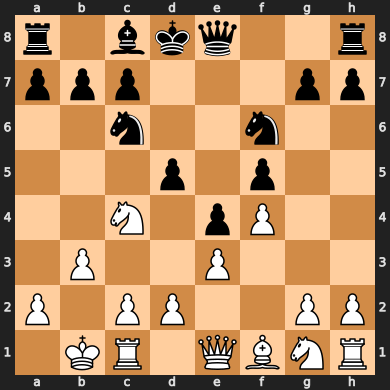

In [91]:
state

Sunfish best move: c4a3
Sunfish moves: ['d2d4', 'c4e5', 'c4b2', 'c4a3']
Player move: c4e5


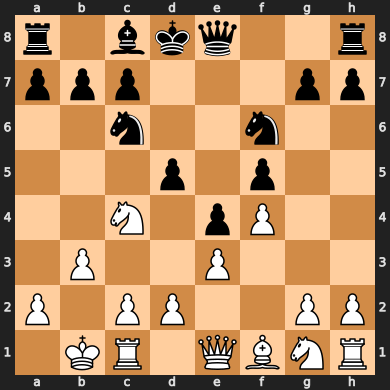

In [99]:
move, best_moves, move_dict = sunfish_move(sf_state, pst, 0.5, move_only=False)
print(f'Sunfish best move: {sunfish_move_to_str(move)}')
print(f'Sunfish moves: {[sunfish_move_to_str(move) for move, score in best_moves.items()]}')
print(f'Player move: {player_move}')

state

In [93]:
move_dict = {sunfish_move_to_str(move): score for move, score in sorted(move_dict.items(), key=lambda item: max(item[1]))}

In [37]:
for move, _ in best_moves.items():
    move = sunfish_move_to_str(move)
    print(move, move_dict[move])

d2d4 [-254, -559, -427, -427, -427, -427, -427, -427, -427, -427, -427, -427, -354, -354]
c4e5 [-405, -379, -379, -379, -379, -379, -379, -379, -303, -303, -379, -339, -346]
c4b2 [-346, -346, -376, -376, -376, -376, -330, -330, -330, -335, -346]
c4a3 [-346, -330, -330, -339, -339, -339, -330, -330, -330, -330, -330, -330, -335, -335, -467, -401, -367, -351, -346, -346]


In [62]:
max_length = max([len(scores) for _, scores in move_dict.items()])
[[move, scores[max_length-10-1]] for move, scores in move_dict.items() if len(scores) >= max_length-10]

[['f1d3', -548],
 ['g2g3', -457],
 ['h2h4', -449],
 ['e1d1', -439],
 ['g1f3', -482],
 ['b1b2', -398],
 ['e1e2', -390],
 ['b1a1', -384],
 ['g2g4', -374],
 ['e1f2', -371],
 ['c4b6', -369],
 ['c4d6', -367],
 ['a2a4', -366],
 ['g1h3', -363],
 ['a2a3', -362],
 ['h2h3', -359],
 ['c2c3', -359],
 ['f1e2', -349],
 ['c1d1', -348],
 ['g1e2', -347],
 ['d2d3', -345],
 ['c4a5', -359],
 ['e1g3', -338],
 ['b3b4', -385],
 ['c4b2', -335],
 ['c4a3', -330],
 ['c4e5', -303],
 ['d2d4', -427],
 ['e1h4', -337]]

In [98]:
max_length = max([len(scores) for _, scores in move_dict.items()])
k = 5
top_moves = set()
for depth in range(max_length, 0, -1):
    moves_at_depth = set([move for move, scores in move_dict.items() if len(scores) >= depth])
    top_moves_new = top_moves | moves_at_depth
    if len(top_moves_new) == k:
        top_moves = top_moves_new
        break
    if len(top_moves_new) > k:
        depth_sorted = [move for move, score in sorted(move_dict.items(), key=lambda item: item[1][max_length-depth]) if move not in top_moves]
        remaining = k - len(top_moves)
        top_moves = top_moves | set(depth_sorted[-remaining:])
        break
    top_moves = top_moves_new
top_moves

{'c4a3', 'c4b2', 'c4e5', 'd2d4', 'e1h4'}

In [96]:
max_length = max([len(scores) for _, scores in move_dict.items()])
k = 4
score_matrix = np.zeros((len(move_dict), max_length))
for i, scores in enumerate(move_dict.values()):
    score_matrix[i, 0:len(scores)] = scores
tied_index = sum((len(move_dict) - (score_matrix == 0).sum(axis = 0)) > k)-1
top_k_moves = move_dict.values()[np.where]

depth_sorted = [move for move, score in sorted(move_dict.items(), key=lambda item: item[1][max_length-depth]) if move not in top_moves]

print((len(move_dict) - (score_matrix == 0).sum(axis = 0)))
print(tied_index)

[29 29 29 29 29 29 29 29 29 29 23  3  3  2  1  1  1  1  1  1]
11


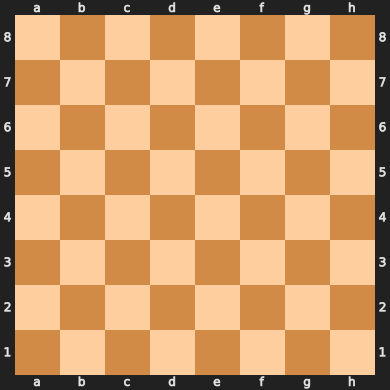

In [75]:
chess.Board('8/8/8/8/8/8/8/8 w')